# Sentiment Analysis of Twitter Data in Python

we are going to perform the Sentiment Analysis of Twitter data live through Twitter’s API.

In [109]:
# import Libraries

import tweepy
import pandas as pd
import numpy as np
import string
import re

import preprocessor as p
import matplotlib.pyplot as plt
from IPython.display import display
import seaborn as sns
from textblob import TextBlob

import nltk
nltk.download('stopwords')

from nltk.corpus import stopwords
from nltk.classify import SklearnClassifier
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud,STOPWORDS

%matplotlib inline

[nltk_data] Downloading package stopwords to C:\Users\waleed
[nltk_data]     traders\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# 1) Business Understanding

Twitter Sentiment Analysis helps to understand people’s views and feelings. It provides additional metrics to analyze the performance of products and services and provides opportunities for improvement.
 
We are going to perform these tasks :

 
1) Scraping tweets through Twitter's tweepy API

2) Categorizing tweets regarding their sentiments (positive, negative, or neutral).
 
3) Examining tweets sentiments with a word cloud 

4) Analyzing hashtags in tweets in bar graph 
 

# 2) Data Understanding

## Gathering Data

In [127]:
# twitter App access keys for @user
 
# Consumer
CONSUMER_KEY    = 'xxxxxxxxxxxxxxxxxxxx'
CONSUMER_SECRET = 'xxxxxxxxxxxxxxxxxxxx'
 
# Access:
ACCESS_TOKEN  = 'xxxxxxxxxxxxxxxxxxxx'
ACCESS_SECRET = 'xxxxxxxxxxxxxxxxxxxx'

In [111]:
def app_auth():
    
    """
    Authenticate our program using the credentials,
    then create a Twitter API object with the credentials
    """
    
    auth = tweepy.OAuthHandler(CONSUMER_KEY, CONSUMER_SECRET)
    auth.set_access_token(ACCESS_TOKEN, ACCESS_SECRET)
    
    api = tweepy.API(auth)
    return api

## Access 

### 1) Scraping tweets through Twitter's tweepy API

In [112]:
tweet_extract = app_auth()

# input for term to be searched and how many tweets to search

search_term = input("Enter keyword or tag to search: ")
no_of_terms = int(input("Enter no: of tweets to search:"))

tweets = tweet_extract.user_timeline(screen_name = search_term, count = no_of_terms)
print('')
print("Number of tweets extracted: {}.\n".format(len(tweets)))

Enter keyword or tag to search: Who
Enter no: of tweets to search:200

Number of tweets extracted: 200.



In [113]:
# display top 10 tweets

print("10 latest tweets are :\n")
for tweet in tweets[:10]:
    print(tweet.text)
    print('\n')

10 latest tweets are :

For live #WHA73 updates, follow @WHO.

You can also check this event page curated by @Twitter 
👇
https://t.co/xy8TFnQpO3


The World Health Assembly #WHA73 starts today.
Health leaders are convening virtually for the first time this year,… https://t.co/FIhSDLMQFd


Live from the virtual #WHA73. #COVID19 https://t.co/UGQ2wCfTUe


We must, first of all, combat this #COVID19 pandemic.
We need to put in place a solution that everyone can stand be… https://t.co/k9vcPqPOR4


WHO is the legitimate world organization for the area of health, so we should continue to work to improve procedure… https://t.co/m89hLhe7xv


It showed that virtually no country has been spared by this pandemic so no country can solve this problem alone.
We… https://t.co/hqagjNgxcY


In the face of crisis human kind must choose solidarity &amp; cooperation over the pursue of individual interest.
The w… https://t.co/6klyN9CAde


This year, the Republic of #Korea is planning to provide humanitarian

### Data is noisy contain links, spaces, special cheracters, hashtags etc.

In [114]:
# Creating a DataFrame of fetch tweets

df = pd.DataFrame(data=[tweet.text for tweet in tweets], columns=['Tweets'])
df['ID'] = np.array([tweet.id for tweet in tweets])
df['Date'] = np.array([tweet.created_at for tweet in tweets])
df['Source'] = np.array([tweet.source for tweet in tweets])
df['Likes'] = np.array([tweet.favorite_count for tweet in tweets])
df['Retweets'] = np.array([tweet.retweet_count for tweet in tweets])
display(df.head(10))

,Tweets,ID,Date,Source,Likes,Retweets
0,"For live #WHA73 updates, follow @WHO.\n\nYou c...",1262473134759981058,2020-05-18 20:00:25,Twitter Web App,12,6
1,The World Health Assembly #WHA73 starts today....,1262469582847184896,2020-05-18 19:46:18,Twitter Web App,66,21
2,Live from the virtual #WHA73. #COVID19 https:/...,1262468869362348032,2020-05-18 19:43:28,Periscope,152,68
3,"We must, first of all, combat this #COVID19 pa...",1262461965739458562,2020-05-18 19:16:02,Twitter for iPhone,173,56
4,WHO is the legitimate world organization for t...,1262460838964867074,2020-05-18 19:11:34,Twitter for iPhone,220,66
5,It showed that virtually no country has been s...,1262459557504339977,2020-05-18 19:06:28,Twitter for iPhone,307,81
6,In the face of crisis human kind must choose s...,1262457412482711554,2020-05-18 18:57:57,Twitter for iPhone,162,47
7,"This year, the Republic of #Korea is planning ...",1262456776705937409,2020-05-18 18:55:25,Twitter for iPhone,124,32
8,Such vaccines and treatments are public goods ...,1262424787776872455,2020-05-18 16:48:18,Twitter for iPhone,271,71
9,Live from the virtual #WHA73 https://t.co/m39P...,1262423962945904640,2020-05-18 16:45:02,Periscope,497,213


### Visualization and basic stats 

Creation of content sources:
* Twitter Web App
* Periscope
* Twitter for iPhone


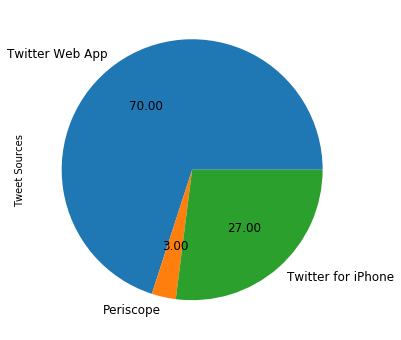

In [115]:
sources = []
for source in df['Source']:
    if source not in sources:
        sources.append(source)
        
        
# We print sources list:

print("Creation of content sources:")
for source in sources:
    print("* {}".format(source))

# We create a numpy vector mapped to labels:

percent = np.zeros(len(sources))
 
for source in df['Source']:
    for index in range(len(sources)):
        if source == sources[index]:
            percent[index] += 1
            pass

percent /= 100
    
# Pie chart:

pie_chart = pd.Series(percent, index=sources, name='Tweet Sources')
pie_chart.plot.pie(fontsize=12, autopct='%.2f', figsize=(6, 6));

In [116]:
# Create a series from array
tweets_liked = pd.Series(data = df['Likes'].values)   
tweets_retweeted = pd.Series(data = df['Retweets'].values) 

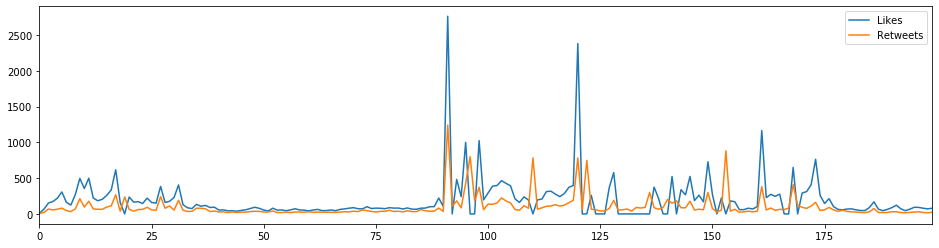

In [117]:
# Likes vs retweets visualization:

tweets_liked.plot(figsize=(16,4), label="Likes", legend=True)
tweets_retweeted.plot(figsize=(16,4), label="Retweets", legend=True)

# 3) Data Preparation

## Clean

Here we are going to clean our Tweets. We are going to: 

1) Remove Links 

2) Special Characters 

3) Remove spaces etc


In [118]:
def clean_tweet(tweet):
    
    """
     Clean data by remove Links, Special Characters etc from tweet
    """
    return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t]) | (\w +:\ / \ / \S +)", " ", tweet).split())

# 4) Data Modeling

In [119]:
# creating some variables and list to store info

polarity = 0
positive = 0
negative = 0
neutral = 0
        
positive_word = []
negtive_word = []

#tweets = []
tweet_text = []

# iterating through tweets fetched
for tweet in tweets:
    
    #Append to temp so that we can store in csv later. I use encode UTF-8
    tweet_text.append(clean_tweet(tweet.text).encode('utf-8'))
    
    # print (tweet.text.translate(non_bmp_map))    #print tweet's text
    analysis = TextBlob(tweet.text)
    
    # print(analysis.sentiment)  # print tweet's polarity
    polarity += analysis.sentiment.polarity
    
    # adding reaction of how people are reacting to find average later
    
    if (analysis.sentiment.polarity == 0): 
        neutral += 1
    elif (analysis.sentiment.polarity > 0 ):
        positive_word.append(tweet.text)
        positive += 1
    elif (analysis.sentiment.polarity < 0):
        negtive_word.append(tweet.text)
        negative += 1

## Analyze

### 2-  Categorizing tweets regarding their sentiments (positive, negative or neutral).

In [120]:
def calculate_percentage(part, whole):
    
    """
    Calculate percentage of tweets polarity
    
    """
    temp = 100 * float(part) / float(whole)
    return format(temp, '.2f')


# finding average of people's sentiments

positive = calculate_percentage(positive, no_of_terms)
negative = calculate_percentage(negative, no_of_terms)
neutral = calculate_percentage(neutral, no_of_terms)

print("Classification of tweets according to the sentments.\n")
print("Percentage of positive tweets: {}%".format(positive))
print("Percentage of neutral tweets: {}%".format(negative))
print("Percentage de negative tweets: {}%".format(neutral))

Classification of tweets according to the sentments.

Percentage of positive tweets: 46.00%
Percentage of neutral tweets: 10.50%
Percentage de negative tweets: 43.50%


# 5) Evaluation and Results

## Visualize 

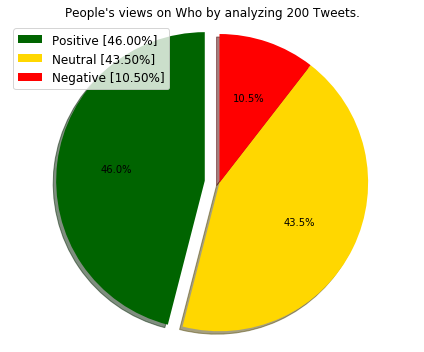

In [121]:
def plot_chart(positive, neutral, negative, search_term, no_of_terms):
    
    """
    Draw pie chart showing classification of sentimets 
    """
     
    labels = ['Positive [' + str(positive) + '%]', 'Neutral [' + str(neutral) + '%]','Negative [' + str(negative) + '%]']
    sizes = [positive, neutral, negative]
    colors = ['darkgreen', 'gold', 'red']
    explode = (0.1, 0, 0)
    fig1, ax1 = plt.subplots(figsize=(6, 5))
    ax1.pie(sizes,colors= colors, explode=explode, autopct='%1.1f%%',shadow=True, startangle=90)
    plt.legend(labels, loc="upper left" , prop={'size': 12})
    plt.title('People\'s views on ' + search_term + ' by analyzing ' + str(no_of_terms) + ' Tweets.')
    ax1.axis('equal')
    plt.tight_layout()
    plt.show()
    

plot_chart(positive, neutral, negative, search_term, no_of_terms)

### 3-  Examining hashtags in tweets in bar graph 

In [122]:
def extract_hashtags(tweets):
    
    """
    Collect hashtags from tweets list by find tweets 
    that start with #
    """
    
    hashtags = []
    # Loop over the words in the tweet
    for tweet in tweets:
        hashtag = re.findall(r"#(\w+)", tweet.text)
        hashtags.append(hashtag)

    return hashtags

# extracting hashtags from tweets
hashtag = extract_hashtags(tweets)

# unnesting list
hashtag = sum(hashtag,[])

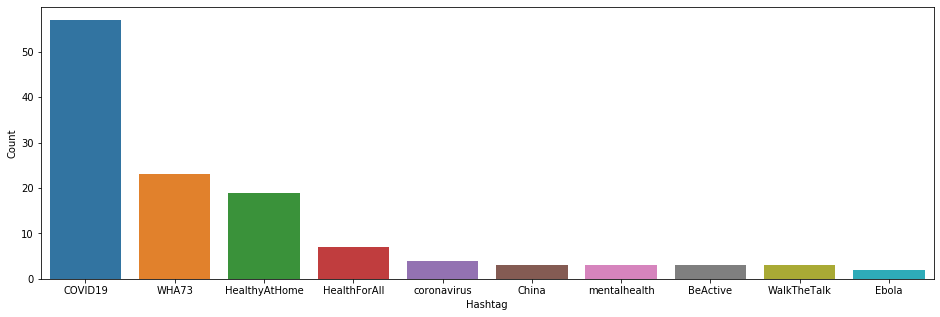

In [123]:
a = nltk.FreqDist(hashtag)
d = pd.DataFrame({'Hashtag': list(a.keys()),
                  'Count': list(a.values())})
# selecting top 10 most frequent hashtags     
d = d.nlargest(columns="Count", n = 10) 
plt.figure(figsize=(16,5))
ax = sns.barplot(data=d, x= "Hashtag", y = "Count")
ax.set(ylabel = 'Count')
plt.show()

### 4- Examining tweets sentiments with word cloud 

In [124]:
def draw_wordcloud(tweets, color = 'black'):
    
    """
    Draw a cloud a word from tweets 
    """
    words = ' '.join(tweets)
    cleaned_word = " ".join([word for word in words.split() 
                             if 'http' not in word
                                    and not word.startswith('@')
                                    and not word.startswith('#')
                                    and word != 'RT'
                            ])
    
    wordcloud = WordCloud(stopwords=STOPWORDS,
                          background_color=color,
                          max_words=100,
                          width=3000,
                          height=1000
                         ).generate(cleaned_word)
    plt.figure(figsize=(13, 13))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis('off')
    plt.show()

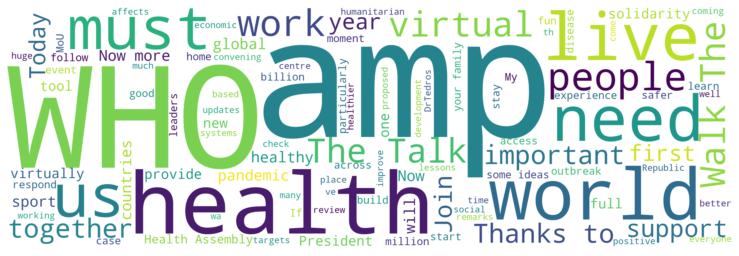

In [125]:
# call function to draw word of cloud with positve sentiments 

draw_wordcloud(positive_word, 'white')

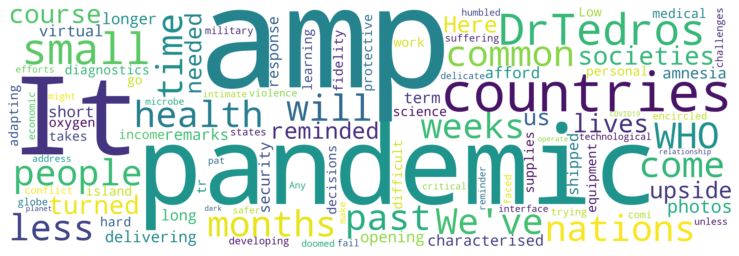

In [126]:
# call function to draw word of cloud with negitive sentiments

draw_wordcloud(negtive_word,'white')